# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 2: Constrained Optimization</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density</li>
    <li>Analyze traffic-density per area during different times of the day</li>

<img src="img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<center>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Imports-&amp;-Settings" data-toc-modified-id="1-Imports-&amp;-Settings-1">1 Imports &amp; Settings</a></span></li><li><span><a href="#2-Data" data-toc-modified-id="2-Data-2">2 Data</a></span><ul class="toc-item"><li><span><a href="#2.1-Paths" data-toc-modified-id="2.1-Paths-2.1">2.1 Paths</a></span></li><li><span><a href="#2.2-Areas" data-toc-modified-id="2.2-Areas-2.2">2.2 Areas</a></span></li><li><span><a href="#2.3-Coefficients" data-toc-modified-id="2.3-Coefficients-2.3">2.3 Coefficients</a></span></li></ul></li><li><span><a href="#3-Optimization" data-toc-modified-id="3-Optimization-3">3 Optimization</a></span></li><li><span><a href="#4-Model-Evaluation" data-toc-modified-id="4-Model-Evaluation-4">4 Model Evaluation</a></span></li><li><span><a href="#5-Visuals" data-toc-modified-id="5-Visuals-5">5 Visuals</a></span><ul class="toc-item"><li><span><a href="#5.1-Coefficients" data-toc-modified-id="5.1-Coefficients-5.1">5.1 Coefficients</a></span></li><li><span><a href="#5.2-Traffic-Density" data-toc-modified-id="5.2-Traffic-Density-5.2">5.2 Traffic Density</a></span></li><li><span><a href="#5.3-Traffic-Speed" data-toc-modified-id="5.3-Traffic-Speed-5.3">5.3 Traffic Speed</a></span></li></ul></li><li><span><a href="#6-Scenario-Analysis" data-toc-modified-id="6-Scenario-Analysis-6">6 Scenario Analysis</a></span><ul class="toc-item"><li><span><a href="#6.1-Load-Coefficients" data-toc-modified-id="6.1-Load-Coefficients-6.1">6.1 Load Coefficients</a></span></li><li><span><a href="#6.2-Distribution-of-Coefficients" data-toc-modified-id="6.2-Distribution-of-Coefficients-6.2">6.2 Distribution of Coefficients</a></span></li><li><span><a href="#6.3-Comparison-by-Area" data-toc-modified-id="6.3-Comparison-by-Area-6.3">6.3 Comparison by Area</a></span></li></ul></li></ul></div>

### 1 Imports & Settings
***

In [1]:
# Library for data handliing
import numpy as np
import pandas as pd
import time

# Library for networkx analysis
import networkx as nx

# Library to split data into train & test set
from sklearn.model_selection import train_test_split

# Library for constrained optimization
from scipy.optimize import minimize

# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for gemoetry & animation
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon as Centroid

In [2]:
# Custom library
import data_areas
import street_network

### 2 Data
***

#### 2.1 Paths

In [3]:
# Load paths data
paths = pd.read_csv("output/paths.csv", sep=",")
paths.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,time_of_day,weekday,weeknum,weekend,EST_CROSSINGS,...,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370
0,317,1267,2,270.67,142.65,16-19,4,8,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1126,638,2,220.74,114.06,19-0,4,8,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,954,422,2,223.30,208.47,10-16,2,7,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,915,928,3,104.00,30.76,0-7,2,13,0,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,954,422,3,163.63,103.31,10-16,0,10,0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_coefs = 1370
idx_num = list(np.arange(1, n_coefs+1).astype("str"))
idx_str = [(lambda x: x.zfill(4))(x) for x in idx_num]

In [6]:
# Splitting between independent matrix and dependent vector 
X = paths[idx_str].astype(float)
y = paths["mean_travel_time"]

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Number of observations in train & test set
n_train = len(X_train)
n_test  = len(X_test)

#### 2.2 Areas

In [7]:
# List of areas not passed by any path in the train set
empty_areas = np.sum(X_train, axis=0)
empty_areas = empty_areas[empty_areas==0].index
empty_areas

Index(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
       '0012',
       ...
       '1360', '1362', '1363', '1364', '1365', '1366', '1367', '1368', '1369',
       '1370'],
      dtype='object', length=992)

In [8]:
# List of areas outside of Vienna
outer_areas = ["1365", "1366", "1367", "1368", "1369", "1370"]

#### 2.3 Coefficients

In [9]:
# Load the initial starting points for coefs
try:
    coefs_init = pd.read_csv("output/coefs.csv", sep=",", index_col="area").squeeze()
    print("Coefficients imported!\n")
    print(coefs_init.tail())
    
except IOError:
    coefs_init = np.random.normal(loc=0.20, scale=0.04, size=n_coefs)
    print("Coefficients are initialized as normally distributed around 0.20!")

Coefficients are imported!

area
1366    0.115761
1367    0.233563
1368    0.161286
1369    0.199292
1370    0.227717
Name: coefs, dtype: float64


### 3 Optimization
***

In [42]:
def loss_func(coefs, **kwargs):
    """
    A function that returns the residual squared error, based on a set of coefs
    
    Parameters
    ----------
    coefs : pd.Series
    test : bool (optional)
    """
    
    if "test" in kwargs:
        if kwargs["test"] is True:
            X, y, n = X_test, y_test, n_test
        
    else:
        X, y, n = X_train, y_train, n_train
    
    est  = np.dot(X,coefs)
    err  = np.sum(np.power(est-y,2))
    rmse = np.sqrt(err/n)
    return rmse


def callback_func(coefs_i):
    """A function that prints runtime at each iteration"""
    
    global start_time, coefs_list, iteration
    
    iteration += 1

    # Track results at each iteration
    rmse = loss_func(coefs_i)
    rmse_list.append(rmse)
    coefs_list.append(pd.Series(coefs_i))
    
    run_time = (time.time() - start_time)/60
    print (f"Iter: {str(iteration)} has {rmse:.4f} RMSE after {run_time:.2f} minutes")

In [49]:
# Boundaries for coefficients
bounds = [(0.03,0.72)] * n_coefs

# Store results at each iteration in list
rmse_list = list()
coefs_list = [coefs_init]

# Counter for iterations
iteration = 0

In [51]:
# Run optimization
start_time = time.time()

result = minimize(
    fun=loss_func, 
    x0=coefs_init,
    bounds=bounds,
    callback=callback_func
)

Iter: 1 has 51.5257 RMSE after 0.08 minutes
Iter: 2 has 50.6499 RMSE after 0.10 minutes
Iter: 3 has 49.4513 RMSE after 0.11 minutes
Iter: 4 has 48.4250 RMSE after 0.15 minutes
Iter: 5 has 46.2064 RMSE after 0.18 minutes
Iter: 6 has 45.4107 RMSE after 0.22 minutes
Iter: 7 has 43.0660 RMSE after 0.24 minutes
Iter: 8 has 41.9639 RMSE after 0.27 minutes


In [68]:
# Output results
coefs = pd.Series(data=result.x, index=idx_str, name="coefs")
coefs.index.name = "area"
coefs.to_csv("output/coefs.csv")

n_it  = result.nit
rmse  = result.fun

print (f"Train RMSE: {rmse:.4f}")

RMSE: 41.9639


### 4 Model Evaluation
***

In [69]:
rmse_test = loss_func(coefs=coefs, test=True)
print (f"Test RMSE: {rmse_test:.4f}")

RMSE: 192.7674


### 5 Visuals
***

#### 5.1 Coefficients

In [72]:
Colors = street_network.NetworkColors()
cpal = Colors.get_cpal(11)
cpal

[(0.8391695501730103, 0.8228373702422145, 0.4374625144175319),
 (0.6783391003460209, 0.8260668973471741, 0.4749250288350635),
 (0.509850057670127, 0.8294502114571318, 0.5141714725105729),
 (0.34901960784313757, 0.8326797385620914, 0.5516339869281047),
 (0.18818915801614766, 0.8359092656670513, 0.5890965013456364),
 (0.027112648981161058, 0.8370165321030373, 0.6266974240676665),
 (0.17760861207227996, 0.7446520569011919, 0.5950480584390619),
 (0.32810457516339864, 0.6522875816993464, 0.5633986928104575),
 (0.48576701268742783, 0.5555247981545559, 0.530242214532872),
 (0.6362629757785467, 0.46316032295271037, 0.49859284890426736),
 (0.7867589388696654, 0.37079584775086527, 0.4669434832756633)]

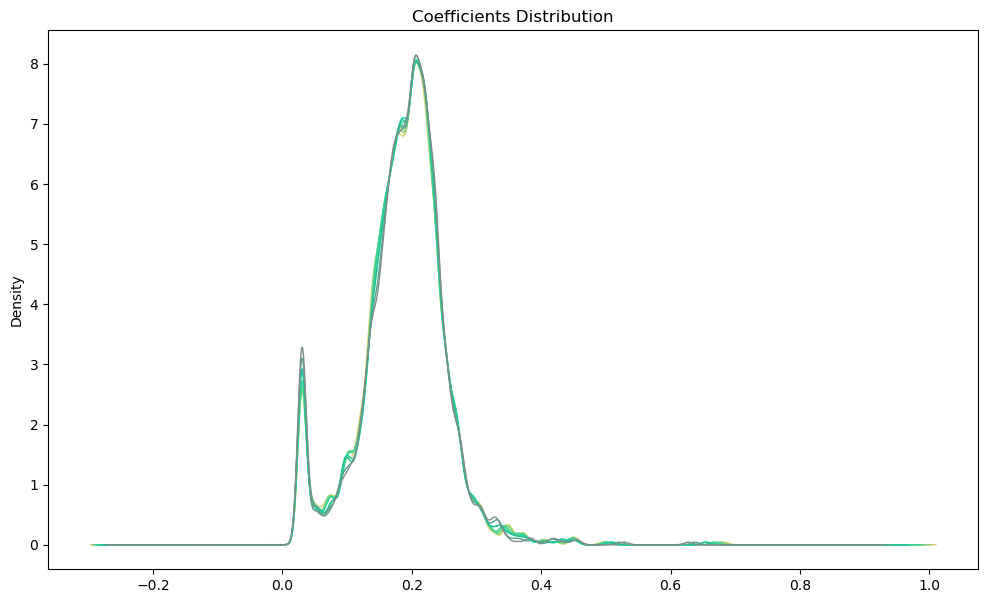

In [122]:
plt.figure(figsize=(12,7))
plt.title("Coefficients Distribution")

for i,j in enumerate(coefs_list):
    j.plot.kde(bw_method=0.1, ind=None, lw=1, color=cpal[i])

#### 5.2 Traffic Density

In [112]:
# Instantiate network graph
Vienna = nx.Graph()

In [113]:
# Call areas class and execute its functions
Areas = data_areas.Areas()
Areas.load_data(filename="vienna_statistical_areas.json")
Areas.load_graph(graph=Vienna)

In [114]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(coefs), vmax=np.max(coefs)*0.8)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

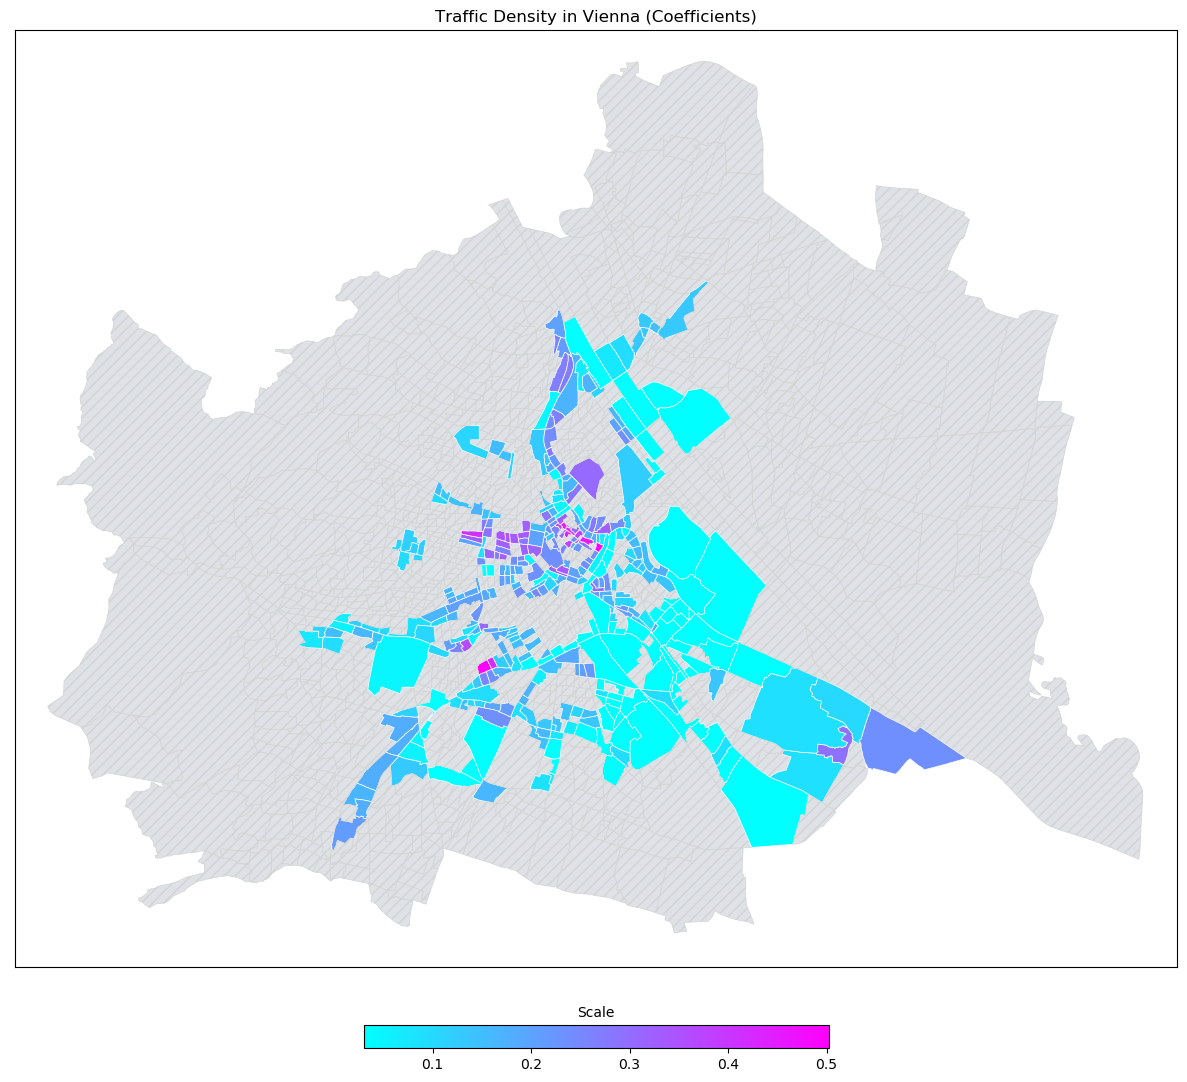

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Coefficients)", fontsize=12)

for key,val in Areas.polygons.items():
    
    idx = int(key)-1
    density = norm(coefs[idx])
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key not in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))
        
        x_center, y_center = Centroid(val).centroid.coords[0]
        # ax.text(x=x_center, y=y_center, s=key, ha="center")

# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Scale", fontsize=10)
plt.savefig("img/coefs.png")
plt.show()

#### 5.3 Traffic Speed

In [30]:
def coef_kmh(coefs):
    """
    A function that converts coefficients from s/m into km/h
    
    Parameters
    ----------
    coefs : np.array
    """
    mps = 1/coefs
    kmh = mps/1000*3600
    
    return kmh

In [31]:
kmh = coef_kmh(coefs=coefs)
kmh

area
0001    20.194803
0002    15.849236
0003    21.622924
0004    17.729454
0005    17.091560
          ...    
1366    31.098557
1367    15.413425
1368    22.320650
1369    18.063972
1370    15.809064
Name: coefs, Length: 1370, dtype: float64

In [32]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(kmh), vmax=np.max(kmh)*0.9)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

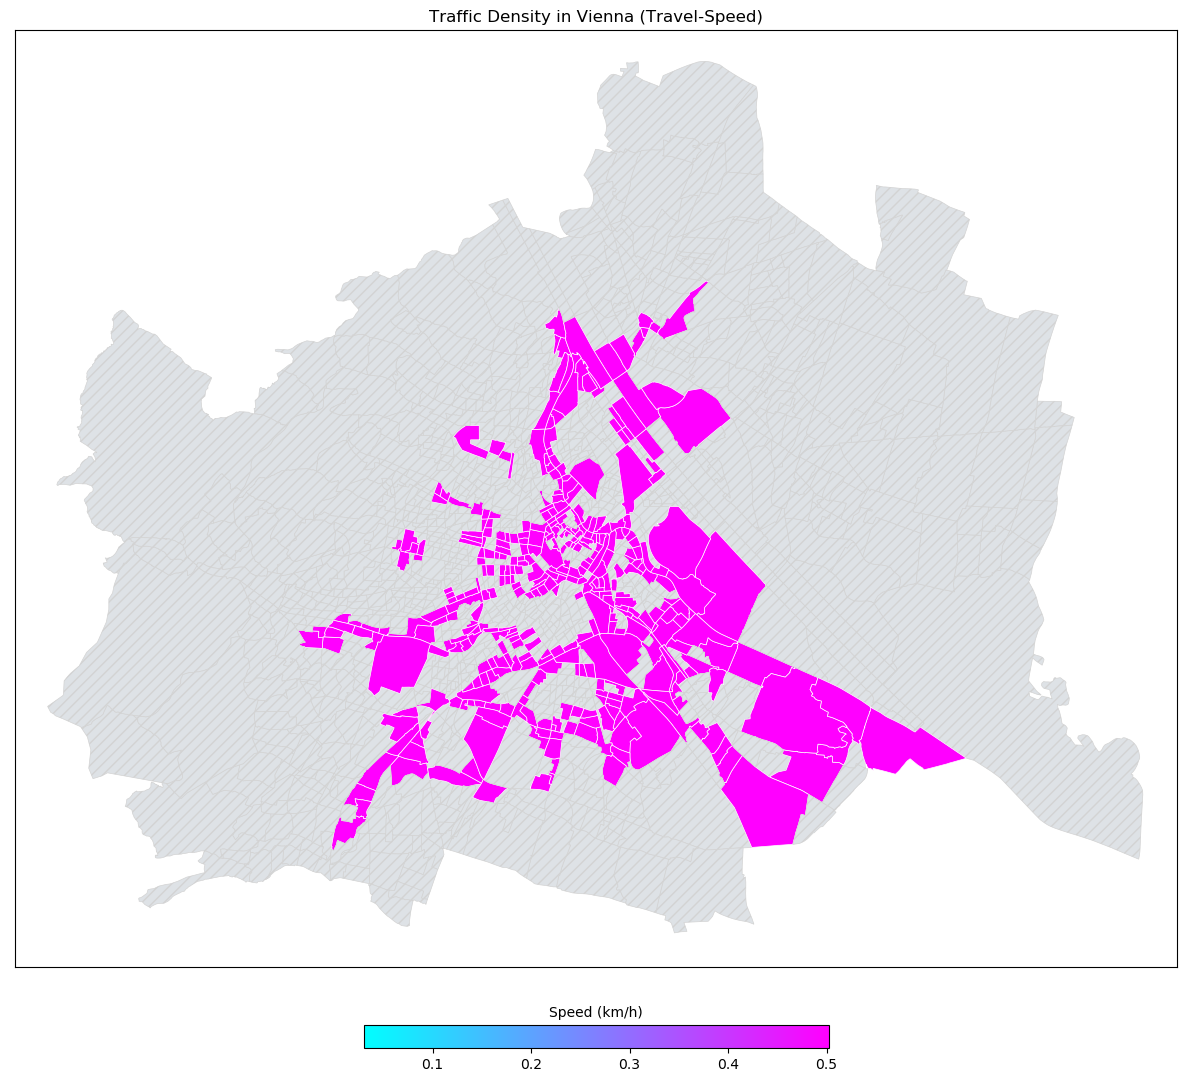

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

# Set axis limits for figure
ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Travel-Speed)", fontsize=12)

for key,val in Areas.polygons.items():
    
    idx = int(key)-1
    density = norm(kmh[idx])
    
    # Skipping plotting for outer areas
    if key in outer_areas:
        continue
    
    # Plot areas with density data
    elif key not in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Plot areas without density data
    elif key in empty_areas:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5))


# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Speed (km/h)", fontsize=10)
plt.savefig("img/speed.png")
plt.show()